# Convolutional Neural Networks

In [ ]:
# Imports
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import sys
import os
import numpy as np
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from six.moves import cPickle
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
%matplotlib inline

### **Load the Data**

In [ ]:
# Load function.
""" ciFAIR data loader for tf.keras. Requires tensorflow >= 1.9.

Version: 1.0

https://cvjena.github.io/cifair/
"""
def load_cifair10():
    """Loads [ciFAIR-10 dataset](https://cvjena.github.io/cifair/).

    This is a variant of the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
    dataset with a duplicate-free test set.
    See the [ciFAIR homepage](https://cvjena.github.io/cifair/) for more information.

    Returns:
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

        **x_train, x_test**: uint8 arrays of RGB image data with shape
            `(num_samples, 3, 32, 32)` if `tf.keras.backend.image_data_format()` is
            `'channels_first'`, or `(num_samples, 32, 32, 3)` if the data format
            is `'channels_last'`.

        **y_train, y_test**: uint8 arrays of category labels
            (integers in range 0-9) each with shape (num_samples, 1).
    """
    dirname = 'ciFAIR-10'
    archive_name = 'ciFAIR-10.zip'
    origin = 'https://github.com/cvjena/cifair/releases/download/v1.0/ciFAIR-10.zip'
    md5_hash = 'ca08fd390f0839693d3fc45c4e49585f'

    path = get_file(archive_name, origin=origin, file_hash=md5_hash, hash_algorithm='md5', extract=True, archive_format='zip')
    path = os.path.join(os.path.dirname(path), dirname)

    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000:i * 10000, :, :, :],
        y_train[(i - 1) * 10000:i * 10000]) = _load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = _load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    x_test = x_test.astype(x_train.dtype)
    y_test = y_test.astype(y_train.dtype)

    return (x_train, y_train), (x_test, y_test)


def _load_batch(fpath, label_key='labels'):
    """Internal utility for parsing ciFAIR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = cPickle.load(f)
            # Encode utf8 to ascii
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.encode('utf-8') if isinstance(k, unicode) else k] = v
            d = d_decoded
        else:
            d = cPickle.load(f, encoding='bytes')
            # Decode bytes to utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf-8') if isinstance(k, bytes) else k] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


Now let's load the dataset and view the shape of our data

In [ ]:
# Load data and split the data between train and test
(x_train, y_train), (x_test, y_test) = load_cifair10()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

168615936/168614301 [==============================] - 39s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


**Checking the distribution of our training and testing data**

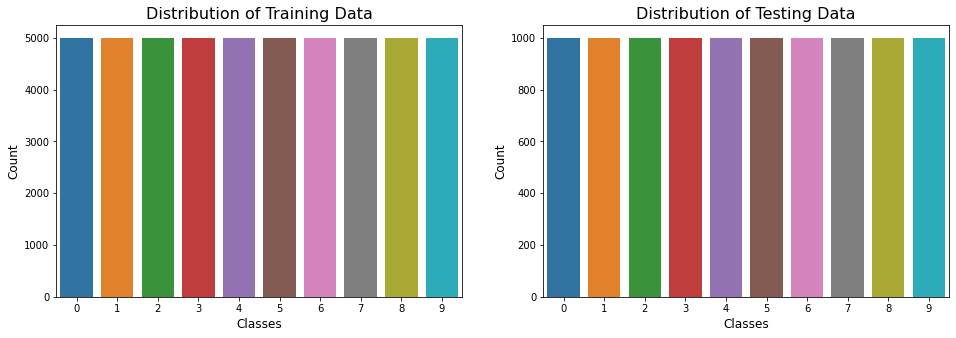

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,5)) 
# Count plot for training set
sns.countplot(x=y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of Training Data', fontsize=16)
axs[0].set_xlabel('Classes', fontsize=12)
axs[0].set_ylabel('Count', fontsize=12)
# Count plot for testing set
sns.countplot(x=y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing Data', fontsize=16)
axs[1].set_xlabel('Classes', fontsize=12)
axs[1].set_ylabel('Count', fontsize=12)
plt.show()

### **Data Visualisation**

Plotting 10 images from each class (100 in total).

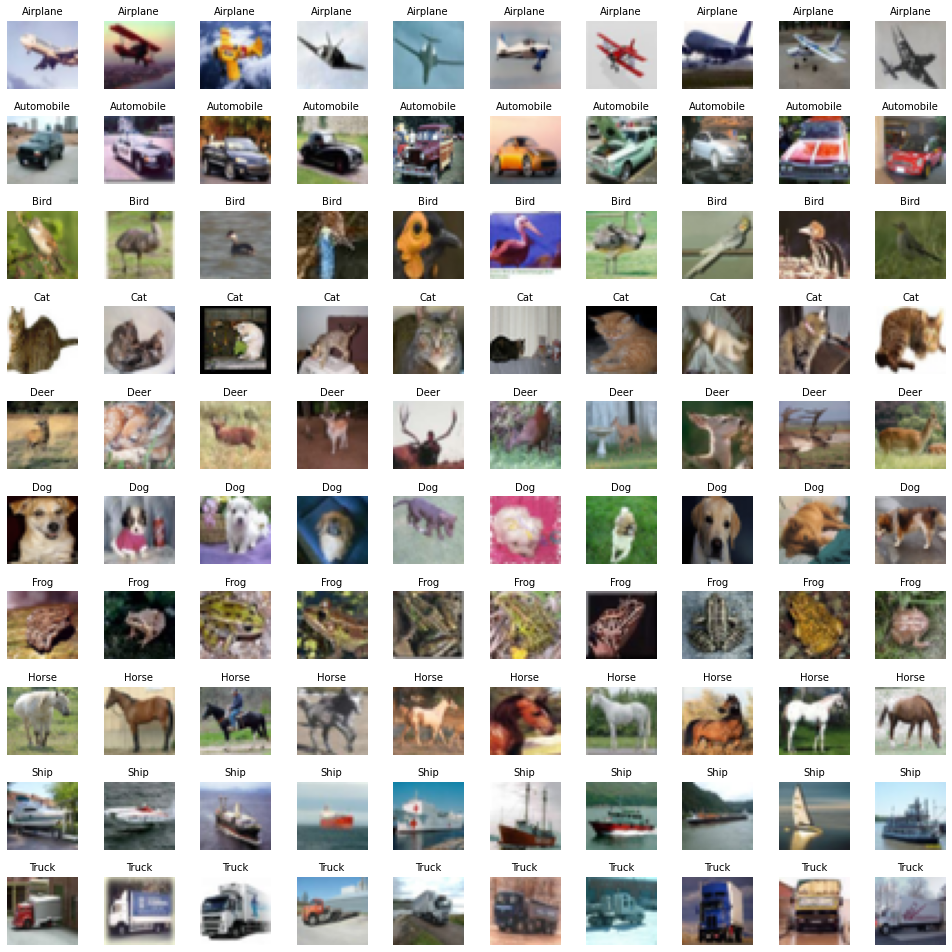

In [ ]:
# Creating 10 empty lists to fill them with the corresponding labels for each class
Airplane = []
Automobile = []
Bird = []
Cat = []
Deer = []
Dog = [] 
Frog = []
Horse = [] 
Ship = []
Truck = []

# Creating a list which contains all above lists
lists = [Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck,]

# Reshaping the y_train from 2D to 1D
y_train = y_train.reshape(-1,)

# Assign the length of the y_train to a variable
y_train_len = len(y_train)

# Append each label to its corresponding class list
for elem in range(0,len(lists)):
  for i in range(0, y_train_len):
    if y_train[i]==elem:
      lists[elem].append(i)

# Define the labels of the dataset.
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
          'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Define the dimensions of the plot grid
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() 

start = 0
end = 10

# Select a random number from 0 to y_train_len
for lst in lists:
  
  
  for i in np.arange(start, end): 
    index = np.random.randint(0, len(lst)-1)
    # Read and display an image with the selected index    
    axes[i].imshow(x_train[lst[index],1:])
    label_index = int(y_train[lst[index]])
    axes[i].set_title(labels[label_index], fontsize = 10)
    axes[i].axis('off')
  
  end+=10
  start+=10
  
  if start == 100:
    if end == 100:
      break

plt.subplots_adjust(hspace=0.4)

### **Data Preprocessing**

Now I am going to convert the type of the data and normalize them. After that I am going to perform one hot encoding.

In [ ]:
# Connvert data type to float for computation
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize the data
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices (One hot encoding)
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Print the sample data
print(y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


Now that we have performed data preprocessing it is time to create the  models.

## **Model 1 (My Model)**

In [ ]:
# Start a Sequential model
model = Sequential()

# Add the convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

### **Model Training**

In [ ]:
batch_size = 64
epochs = 15

# Compile the model with the specified loss function, optimization algorithm, 
# and evaluation metric
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data for a specified number of epochs, 
# and evaluate it on the test data at the end of each epoch
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test))

Epoch 1/15
782/782 [==============================] - 13s 6ms/step - loss: 1.6300 - accuracy: 0.4128 - val_loss: 1.3637 - val_accuracy: 0.5132
Epoch 2/15
782/782 [==============================] - 4s 5ms/step - loss: 1.1974 - accuracy: 0.5763 - val_loss: 1.1791 - val_accuracy: 0.5817
Epoch 3/15
782/782 [==============================] - 4s 6ms/step - loss: 0.9856 - accuracy: 0.6505 - val_loss: 1.0721 - val_accuracy: 0.6224
Epoch 4/15
782/782 [==============================] - 4s 6ms/step - loss: 0.8352 - accuracy: 0.7051 - val_loss: 1.0421 - val_accuracy: 0.6432
Epoch 5/15
782/782 [==============================] - 4s 5ms/step - loss: 0.6921 - accuracy: 0.7559 - val_loss: 1.0829 - val_accuracy: 0.6420
Epoch 6/15
782/782 [==============================] - 7s 9ms/step - loss: 0.5530 - accuracy: 0.8040 - val_loss: 1.0614 - val_accuracy: 0.6604
Epoch 7/15
782/782 [==============================] - 7s 9ms/step - loss: 0.4210 - accuracy: 0.8527 - val_loss: 1.1761 - val_accuracy: 0.6527
Epoch

**Model Prediction**

In [ ]:
# Make Prediction
pred = model.predict(x_test)
Y_pred_classes = np.argmax(pred, axis=1)
Y_true = np.argmax(y_test, axis=1) 

313/313 [==============================] - 1s 2ms/step


### **Model Evaluation**

**Model Metrics**

In [ ]:
# Training and Testing Scores
model_test_scores = model.evaluate(x_test, y_test, verbose=1)
model_train_scores = model.evaluate(x_train, y_train, verbose=1)
print(' ')
print('Test Loss:', model_test_scores[0])
print('Test Accuracy:', model_test_scores[1])
print('----------------------------------')
print('Train Loss:', model_train_scores[0])
print('Train Accuracy:', model_train_scores[1])

1563/1563 [==============================] - 5s 3ms/step - loss: 0.0406 - accuracy: 0.9865
 
Test Loss: 2.459073543548584
Test Accuracy: 0.6489999890327454
----------------------------------
Train Loss: 0.04063758999109268
Train Accuracy: 0.986519992351532


**Plotting Curves**

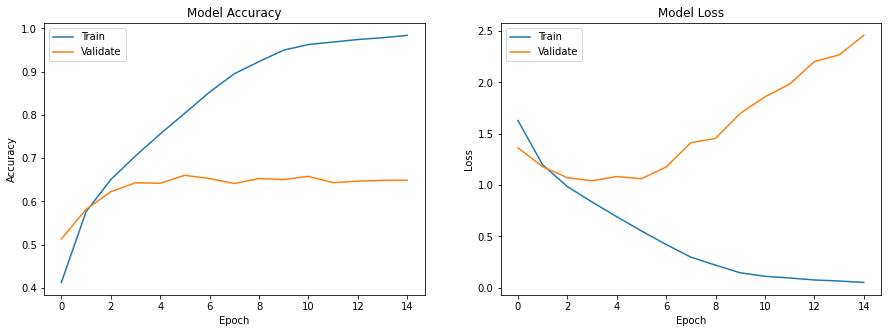

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Summarize history for accuracy
axs[0].plot(history.history['accuracy']) 
axs[0].plot(history.history['val_accuracy']) 
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validate'], loc='upper left')
    
# Summarize history for loss
axs[1].plot(history.history['loss']) 
axs[1].plot(history.history['val_loss']) 
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss') 
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validate'], loc='upper left')
plt.show()

**Confusion Matrix**

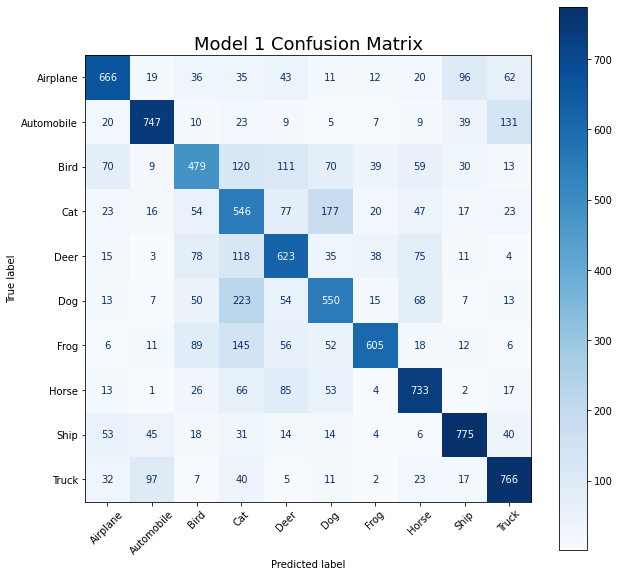

In [ ]:
cm = confusion_matrix(Y_true, Y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation=45, ax=ax,cmap='Blues')
plt.title('Model 1 Confusion Matrix', fontsize=18)
plt.show()

**Classification report**

In [ ]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70      1000
           1       0.78      0.75      0.76      1000
           2       0.57      0.48      0.52      1000
           3       0.41      0.55      0.47      1000
           4       0.58      0.62      0.60      1000
           5       0.56      0.55      0.56      1000
           6       0.81      0.60      0.69      1000
           7       0.69      0.73      0.71      1000
           8       0.77      0.78      0.77      1000
           9       0.71      0.77      0.74      1000

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



### **Improving Model**

Define our improved model

In [ ]:
# Start a Sequential model
model_impr = Sequential()

# Add the convolutional layers
model_impr.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model_impr.add(BatchNormalization())
model_impr.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_impr.add(BatchNormalization())
model_impr.add(MaxPooling2D((2, 2)))
model_impr.add(Dropout(0.5))

# Add the convolutional layers
model_impr.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_impr.add(BatchNormalization())
model_impr.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_impr.add(BatchNormalization())
model_impr.add(MaxPooling2D((2, 2)))
model_impr.add(Dropout(0.5))

# Add the convolutional layers
model_impr.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_impr.add(BatchNormalization())
model_impr.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_impr.add(BatchNormalization())
model_impr.add(MaxPooling2D((2, 2)))
model_impr.add(Dropout(0.5))

# Flatten the output of the convolutional layers
model_impr.add(Flatten())

# Add the fully connected layers
model_impr.add(Dense(512, activation='relu'))
model_impr.add(BatchNormalization())
model_impr.add(Dropout(0.5))
model_impr.add(Dense(10, activation='softmax'))

In [ ]:
# Model Summary
model_impr.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

### **Model Training**

In [ ]:
batch_size_impr = 64
epochs_impr = 30

# Compile the model with the specified loss function, optimization algorithm, 
# and evaluation metric
model_impr.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

# Train the model on the training data for a specified number of epochs, 
# and evaluate it on the test data at the end of each epoch
history_impr = model_impr.fit(x_train, y_train, batch_size=batch_size_impr, epochs=epochs_impr, validation_data=(x_test,y_test))

Epoch 1/30
782/782 [==============================] - 10s 11ms/step - loss: 1.8305 - accuracy: 0.3900 - val_loss: 1.6182 - val_accuracy: 0.4454
Epoch 2/30
782/782 [==============================] - 8s 10ms/step - loss: 1.2614 - accuracy: 0.5489 - val_loss: 1.1677 - val_accuracy: 0.5919
Epoch 3/30
782/782 [==============================] - 8s 10ms/step - loss: 1.0295 - accuracy: 0.6349 - val_loss: 0.9924 - val_accuracy: 0.6586
Epoch 4/30
782/782 [==============================] - 8s 10ms/step - loss: 0.9235 - accuracy: 0.6750 - val_loss: 0.8634 - val_accuracy: 0.7020
Epoch 5/30
782/782 [==============================] - 8s 10ms/step - loss: 0.8398 - accuracy: 0.7049 - val_loss: 0.8673 - val_accuracy: 0.7100
Epoch 6/30
782/782 [==============================] - 8s 10ms/step - loss: 0.7878 - accuracy: 0.7225 - val_loss: 0.8309 - val_accuracy: 0.7168
Epoch 7/30
782/782 [==============================] - 8s 11ms/step - loss: 0.7436 - accuracy: 0.7395 - val_loss: 0.6506 - val_accuracy: 0.773

In [ ]:
# Make Prediction
pred_impr = model_impr.predict(x_test)
Y_pred_classes_impr = np.argmax(pred_impr, axis=1)
Y_true_impr = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 3ms/step


### **Reevaluating Model**

**Final Model Metrics**

In [ ]:
# Training and Testing Scores
model_impr_test_scores = model_impr.evaluate(x_test, y_test, verbose=1)
model_impr_train_scores = model_impr.evaluate(x_train, y_train, verbose=1)
print(' ')
print('Test Loss:', model_impr_test_scores[0])
print('Test Accuracy:', model_impr_test_scores[1])
print('----------------------------------')
print('Train Loss:', model_impr_train_scores[0])
print('Train Accuracy:', model_impr_train_scores[1])

1563/1563 [==============================] - 6s 4ms/step - loss: 0.2040 - accuracy: 0.9315
 
Test Loss: 0.48003676533699036
Test Accuracy: 0.8414000272750854
----------------------------------
Train Loss: 0.2040245532989502
Train Accuracy: 0.9314600229263306


**Plotting Curves**

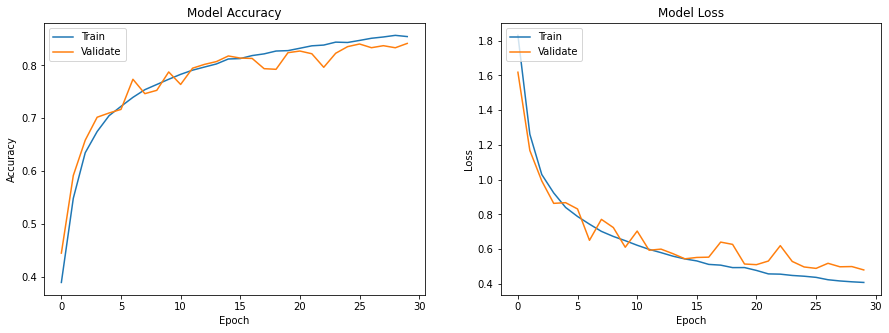

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Summarize history for accuracy
axs[0].plot(history_impr.history['accuracy']) 
axs[0].plot(history_impr.history['val_accuracy']) 
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validate'], loc='upper left')
    
# Summarize history for loss
axs[1].plot(history_impr.history['loss']) 
axs[1].plot(history_impr.history['val_loss']) 
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss') 
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validate'], loc='upper left')
plt.show()

**Confusion Matrix**

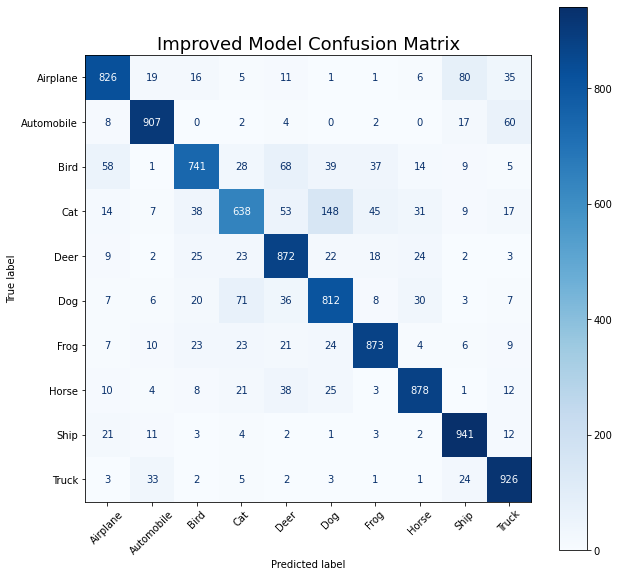

In [ ]:
cm = confusion_matrix(Y_true_impr, Y_pred_classes_impr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation=45, ax=ax,cmap='Blues')
plt.title('Improved Model Confusion Matrix', fontsize=18)
plt.show()

**Classification report**

In [ ]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70      1000
           1       0.78      0.75      0.76      1000
           2       0.57      0.48      0.52      1000
           3       0.41      0.55      0.47      1000
           4       0.58      0.62      0.60      1000
           5       0.56      0.55      0.56      1000
           6       0.81      0.60      0.69      1000
           7       0.69      0.73      0.71      1000
           8       0.77      0.78      0.77      1000
           9       0.71      0.77      0.74      1000

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



### **Save model and weights**

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_My_model.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/cifar10_My_model.h5 


## **Model 2 (LeNet)**

In [ ]:
# This model is inspired by the original LeNet architecture, 
# which was developed for classifying handwritten digits. 

# Define the model architecture
LeNet = Sequential()

# Add the convolutional layers
LeNet.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)))
LeNet.add(MaxPooling2D(pool_size=(2, 2)))
LeNet.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
LeNet.add(MaxPooling2D(pool_size=(2, 2)))

# Add the fully connected layers
LeNet.add(Flatten())
LeNet.add(Dense(units=120, activation='relu'))
LeNet.add(Dense(units=84, activation='relu'))
LeNet.add(Dense(units=num_classes, activation='softmax'))

In [ ]:
LeNet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_4 (Dense)             (None, 120)              

### **Model Training**

In [ ]:
batch_size_le = 64
epochs_le = 30

# Compile AlexNet Model
LeNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train AlexNet Model
LeHistory = LeNet.fit(x_train, y_train, batch_size=batch_size_le, epochs=epochs_le, validation_data=(x_test,y_test))

Epoch 1/30
782/782 [==============================] - 4s 5ms/step - loss: 1.6790 - accuracy: 0.3871 - val_loss: 1.5017 - val_accuracy: 0.4488
Epoch 2/30
782/782 [==============================] - 4s 5ms/step - loss: 1.4121 - accuracy: 0.4894 - val_loss: 1.3778 - val_accuracy: 0.4981
Epoch 3/30
782/782 [==============================] - 4s 5ms/step - loss: 1.2757 - accuracy: 0.5434 - val_loss: 1.2791 - val_accuracy: 0.5413
Epoch 4/30
782/782 [==============================] - 4s 5ms/step - loss: 1.1860 - accuracy: 0.5788 - val_loss: 1.2543 - val_accuracy: 0.5492
Epoch 5/30
782/782 [==============================] - 4s 5ms/step - loss: 1.1240 - accuracy: 0.5998 - val_loss: 1.2193 - val_accuracy: 0.5675
Epoch 6/30
782/782 [==============================] - 4s 5ms/step - loss: 1.0736 - accuracy: 0.6177 - val_loss: 1.1623 - val_accuracy: 0.5932
Epoch 7/30
782/782 [==============================] - 4s 5ms/step - loss: 1.0304 - accuracy: 0.6371 - val_loss: 1.1449 - val_accuracy: 0.5930
Epoch 

In [ ]:
# Make Prediction
pred_le = LeNet.predict(x_test)
Y_pred_classes_le = np.argmax(pred_le, axis=1)
Y_true_le = np.argmax(y_test, axis=1) 

313/313 [==============================] - 1s 2ms/step


### **Model Evaluation**

**Final Metrics**

In [ ]:
# Score trained model
LeNet_test_scores = LeNet.evaluate(x_test, y_test, verbose=1)
LeNet_train_scores = LeNet.evaluate(x_train, y_train, verbose=1)
print(' ')
print('Test Loss:', LeNet_test_scores[0])
print('Test Accuracy:', LeNet_test_scores[1])
print('----------------------------------')
print('Train Loss:', LeNet_train_scores[0])
print('Train Accuracy:', LeNet_train_scores[1])

1563/1563 [==============================] - 4s 3ms/step - loss: 0.4639 - accuracy: 0.8332
 
Test Loss: 1.514553189277649
Test Accuracy: 0.6065999865531921
----------------------------------
Train Loss: 0.4638706147670746
Train Accuracy: 0.8331999778747559


**Plotting Curves**

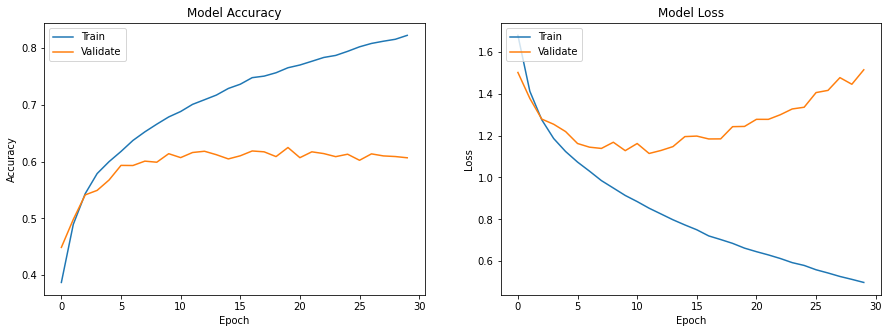

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Summarize history for accuracy
axs[0].plot(LeHistory.history['accuracy']) 
axs[0].plot(LeHistory.history['val_accuracy']) 
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validate'], loc='upper left')
    
# Summarize history for loss
axs[1].plot(LeHistory.history['loss']) 
axs[1].plot(LeHistory.history['val_loss']) 
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss') 
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validate'], loc='upper left')
plt.show()

**Confusion Matrix**

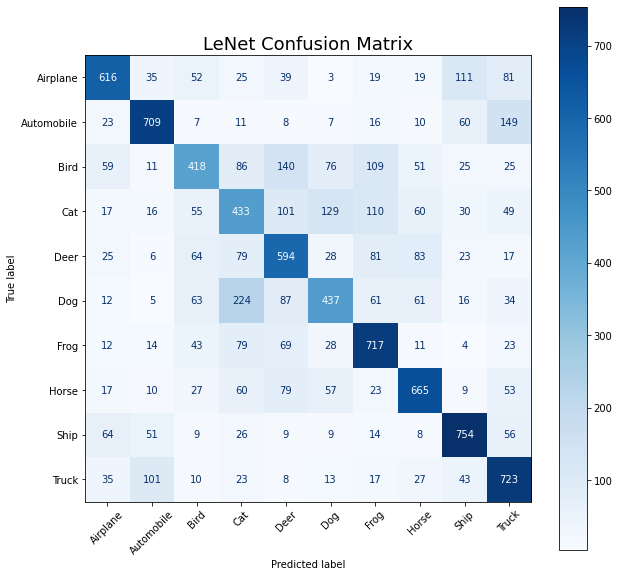

In [ ]:
cm = confusion_matrix(Y_true_le, Y_pred_classes_le)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation=45, ax=ax,cmap='Blues')
plt.title('LeNet Confusion Matrix', fontsize=18)
plt.show()

**Classification report**

In [ ]:
print(classification_report(Y_true_le, Y_pred_classes_le))

              precision    recall  f1-score   support

           0       0.70      0.62      0.66      1000
           1       0.74      0.71      0.72      1000
           2       0.56      0.42      0.48      1000
           3       0.41      0.43      0.42      1000
           4       0.52      0.59      0.56      1000
           5       0.56      0.44      0.49      1000
           6       0.61      0.72      0.66      1000
           7       0.67      0.67      0.67      1000
           8       0.70      0.75      0.73      1000
           9       0.60      0.72      0.65      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.60     10000
weighted avg       0.61      0.61      0.60     10000



## **Model 3 (VGGNet)**

In [ ]:
# This model is inspired by the VGGNet architecture, 
# which was developed for different use cases. 

VGGNet = Sequential()

# Block 1
VGGNet.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
VGGNet.add(Activation('relu'))
VGGNet.add(Conv2D(32, (3, 3), padding='same'))
VGGNet.add(Activation('relu'))
VGGNet.add(MaxPooling2D(pool_size=(2, 2)))
VGGNet.add(Dropout(0.25))

# Block 2
VGGNet.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3)))
VGGNet.add(Activation('relu'))
VGGNet.add(Conv2D(64, (3, 3), padding='same'))
VGGNet.add(Activation('relu'))
VGGNet.add(MaxPooling2D(pool_size=(2, 2)))
VGGNet.add(Dropout(0.25))

# Block 3
VGGNet.add(Conv2D(128, (3, 3), padding='same'))
VGGNet.add(Activation('relu'))
VGGNet.add(Conv2D(128, (3, 3), padding='same'))
VGGNet.add(Activation('relu'))
VGGNet.add(MaxPooling2D(pool_size=(2, 2)))
VGGNet.add(Dropout(0.25))

# Classification block
VGGNet.add(Flatten())
VGGNet.add(Dense(4096))
VGGNet.add(Activation('relu'))
VGGNet.add(Dropout(0.5))
VGGNet.add(Dense(4096))
VGGNet.add(Activation('relu'))
VGGNet.add(Dropout(0.5))
VGGNet.add(Dense(10))
VGGNet.add(Activation('softmax'))

In [ ]:
# Model Summary
VGGNet.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_15 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_16 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 32)        0         
                                                      

### **Model Training**

In [ ]:
batch_size_vgg = 64
epochs_vgg = 30

# Compile VGGNet Model
VGGNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train VGGNet Model
VggHistory = VGGNet.fit(x_train, y_train, batch_size=batch_size_vgg, epochs=epochs_vgg, validation_data=(x_test,y_test))

Epoch 1/30
782/782 [==============================] - 13s 15ms/step - loss: 1.7962 - accuracy: 0.3252 - val_loss: 1.4716 - val_accuracy: 0.4513
Epoch 2/30
782/782 [==============================] - 12s 15ms/step - loss: 1.3959 - accuracy: 0.4896 - val_loss: 1.3107 - val_accuracy: 0.5219
Epoch 3/30
782/782 [==============================] - 12s 15ms/step - loss: 1.2381 - accuracy: 0.5537 - val_loss: 1.0962 - val_accuracy: 0.6162
Epoch 4/30
782/782 [==============================] - 12s 16ms/step - loss: 1.1354 - accuracy: 0.5971 - val_loss: 0.9927 - val_accuracy: 0.6499
Epoch 5/30
782/782 [==============================] - 13s 17ms/step - loss: 1.0592 - accuracy: 0.6220 - val_loss: 0.9917 - val_accuracy: 0.6526
Epoch 6/30
782/782 [==============================] - 13s 17ms/step - loss: 1.0092 - accuracy: 0.6439 - val_loss: 0.9100 - val_accuracy: 0.6858
Epoch 7/30
782/782 [==============================] - 13s 16ms/step - loss: 0.9563 - accuracy: 0.6622 - val_loss: 0.9172 - val_accuracy:

In [ ]:
# Make Prediction
pred_vgg = VGGNet.predict(x_test)
Y_pred_classes_vgg = np.argmax(pred_vgg, axis=1)
Y_true_vgg = np.argmax(y_test, axis=1) 

313/313 [==============================] - 1s 2ms/step


### **Model Evaluation**

**Model Metrics**

In [ ]:
# Training and Testing Scores
VGGNet_test_scores = VGGNet.evaluate(x_test, y_test, verbose=1)
VGGNet_train_scores = VGGNet.evaluate(x_train, y_train, verbose=1)
print(' ')
print('Test Loss:', VGGNet_test_scores[0])
print('Test Accuracy:', VGGNet_test_scores[1])
print('----------------------------------')
print('Train Loss:', VGGNet_train_scores[0])
print('Train Accuracy:', VGGNet_train_scores[1])

1563/1563 [==============================] - 6s 4ms/step - loss: 0.4711 - accuracy: 0.8473
 
Test Loss: 0.6799831390380859
Test Accuracy: 0.7659000158309937
----------------------------------
Train Loss: 0.4711163640022278
Train Accuracy: 0.8473399877548218


**Plotting Curves**

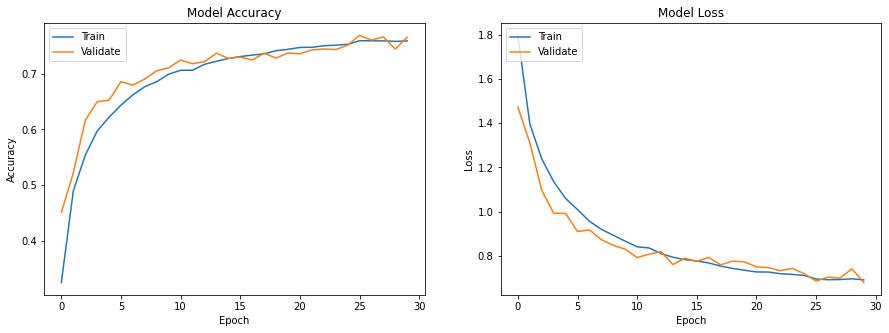

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Summarize history for accuracy
axs[0].plot(VggHistory.history['accuracy']) 
axs[0].plot(VggHistory.history['val_accuracy']) 
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validate'], loc='upper left')
    
# Summarize history for loss
axs[1].plot(VggHistory.history['loss']) 
axs[1].plot(VggHistory.history['val_loss']) 
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss') 
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validate'], loc='upper left')
plt.show()

**Confusion Matrix**

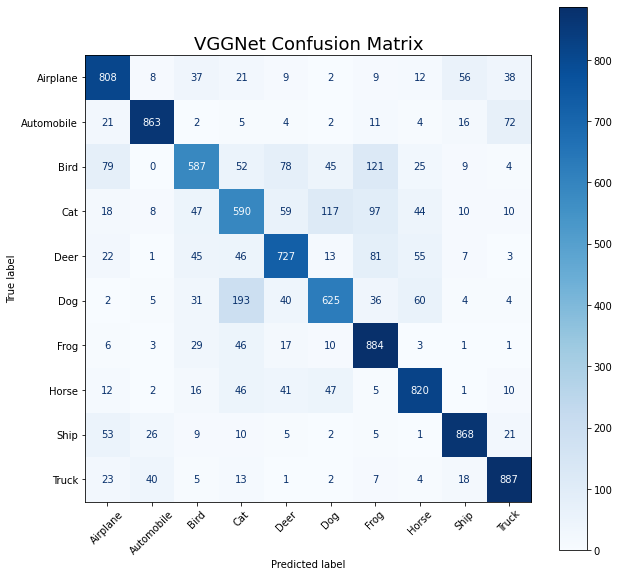

In [ ]:
cm = confusion_matrix(Y_true_vgg, Y_pred_classes_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation=45, ax=ax,cmap='Blues')
plt.title('VGGNet Confusion Matrix', fontsize=18)
plt.show()

**Classification report**

In [ ]:
print(classification_report(Y_true_vgg, Y_pred_classes_vgg))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1000
           1       0.90      0.86      0.88      1000
           2       0.73      0.59      0.65      1000
           3       0.58      0.59      0.58      1000
           4       0.74      0.73      0.73      1000
           5       0.72      0.62      0.67      1000
           6       0.70      0.88      0.78      1000
           7       0.80      0.82      0.81      1000
           8       0.88      0.87      0.87      1000
           9       0.84      0.89      0.87      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.76     10000
weighted avg       0.77      0.77      0.76     10000



## **Compare the 4 Models**

**Plotting the Accuracy curves for each model**

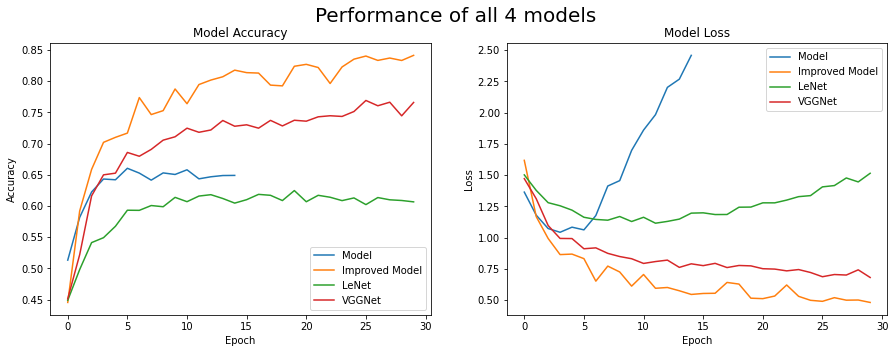

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Summarize history for accuracy

axs[0].plot(history.history['val_accuracy'])
axs[0].plot(history_impr.history['val_accuracy'])
axs[0].plot(LeHistory.history['val_accuracy'])   
axs[0].plot(VggHistory.history['val_accuracy']) 
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epoch')
axs[0].legend(['Model', 'Improved Model', 'LeNet', 'VGGNet'], loc='lower right')
    
# Summarize history for loss
axs[1].plot(history.history['val_loss']) 
axs[1].plot(history_impr.history['val_loss']) 
axs[1].plot(LeHistory.history['val_loss']) 
axs[1].plot(VggHistory.history['val_loss']) 
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss') 
axs[1].set_xlabel('Epoch')
axs[1].legend(['Model', 'Improved Model', 'LeNet', 'VGGNet'], loc='upper right')
fig.suptitle('Performance of all 4 models', fontsize=20)
plt.show()